# Here's the ReadMe for the dataset:

## Detailed description
The Million Playlist Dataset consists of 1,000 slice files. These files have the naming convention of:

mpd.slice._STARTING\_PLAYLIST\_ID\_-\_ENDING\_PLAYLIST\_ID_.json

For example, the first 1,000 playlists in the MPD are in a file called 
`mpd.slice.0-999.json` and the last 1,000 playlists are in a file called
`mpd.slice.999000-999999.json`.

Each slice file is a JSON dictionary with two fields:
*info* and *playlists*.

### `info` Field
The info field is a dictionary that contains general information about the particular slice:

   * **slice** - the range of slices that in in this particular file - such as 0-999
   * ***version*** -  - the current version of the MPD (which should be v1)
   * ***description*** - a description of the MPD
   * ***license*** - licensing info for the MPD
   * ***generated_on*** - a timestamp indicating when the slice was generated.

### `playlists` field 
This is an array that typically contains 1,000 playlists. Each playlist is a dictionary that contains the following fields:


* ***pid*** - integer - playlist id - the MPD ID of this playlist. This is an integer between 0 and 999,999.
* ***name*** - string - the name of the playlist 
* ***description*** - optional string - if present, the description given to the playlist.  Note that user-provided playlist descrptions are a relatively new feature of Spotify, so most playlists do not have descriptions.
* ***modified_at*** - seconds - timestamp (in seconds since the epoch) when this playlist was last updated. Times are rounded to midnight GMT of the date when the playlist was last updated.
* ***num_artists*** - the total number of unique artists for the tracks in the playlist.
* ***num_albums*** - the number of unique albums for the tracks in the playlist
* ***num_tracks*** - the number of tracks in the playlist
* ***num_followers*** - the number of followers this playlist had at the time the MPD was created. (Note that the follower count does not including the playlist creator)
* ***num_edits*** - the number of separate editing sessions. Tracks added in a two hour window are considered to be added in a single editing session.
* ***duration_ms*** - the total duration of all the tracks in the playlist (in milliseconds)
* ***collaborative*** -  boolean - if true, the playlist is a collaborative playlist. Multiple users may contribute tracks to a collaborative playlist.
* ***tracks*** - an array of information about each track in the playlist. Each element in the array is a dictionary with the following fields:
   * ***track_name*** - the name of the track
   * ***track_uri*** - the Spotify URI of the track
   * ***album_name*** - the name of the track's album
   * ***album_uri*** - the Spotify URI of the album
   * ***artist_name*** - the name of the track's primary artist
   * ***artist_uri*** - the Spotify URI of track's primary artist
   * ***duration_ms*** - the duration of the track in milliseconds
   * ***pos*** - the position of the track in the playlist (zero-based)

In [1]:
# import re
# import seaborn as sns
# import time
# import lightgbm as lgbm
# from pathlib import Path
# import pickle
# from catboost import CatBoostClassifier, cv, Pool
# import scikitplot as skplt
# from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, tpe, partial
# import plotly.graph_objects as go


# import itertools
# from itertools import combinations

# import scipy as sp
# from scipy.stats import pearsonr, chi2_contingency

# import matplotlib as mpl

# import matplotlib.cm as cm
# from matplotlib.colors import ListedColormap
# from matplotlib import rc

# import datetime
# from dateutil import relativedelta

# # from IPython.display import display
# # pd.options.display.max_columns = None
# # pd.options.display.max_colwidth = None
# # pd.options.display.max_rows = None

# import statsmodels.api as sm 
# from statsmodels.graphics.api import abline_plot # For visualling evaluating predictions.
# from statsmodels.stats.proportion import proportion_confint

# import warnings # For handling error messages.
# warnings.simplefilter(action="ignore", category=FutureWarning)
# warnings.filterwarnings('ignore')

# import sklearn.metrics as met
# from sklearn import linear_model, preprocessing, model_selection, svm, datasets
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
# from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE
# from sklearn.linear_model import LassoCV, LogisticRegression, Lasso
# from sklearn.metrics import plot_confusion_matrix, auc, confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score, plot_roc_curve
# from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
# from sklearn.neighbors import KNeighborsClassifier 
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import scale, StandardScaler, LabelEncoder, MinMaxScaler, Binarizer
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier

# from bayes_opt import BayesianOptimization
# from bayes_opt.logger import JSONLogger
# from bayes_opt.event import Events
# from bayes_opt.util import load_logs

# from surprise import SVD, BaselineOnly, KNNBasic, KNNWithMeans,KNNWithZScore, KNNBaseline
# from surprise.model_selection import cross_validate

#definitely need
import pandas as pd
import numpy as np
from scipy import sparse
from lightfm import LightFM, evaluation, cross_validation
from sklearn.metrics.pairwise import cosine_similarity
import json
import matplotlib.pyplot as plt

C:\Users\Ernie\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
# @inproceedings{DBLP:conf/recsys/Kula15,
#   author    = {Maciej Kula},
#   editor    = {Toine Bogers and
#                Marijn Koolen},
#   title     = {Metadata Embeddings for User and Item Cold-start Recommendations},
#   booktitle = {Proceedings of the 2nd Workshop on New Trends on Content-Based Recommender
#                Systems co-located with 9th {ACM} Conference on Recommender Systems
#                (RecSys 2015), Vienna, Austria, September 16-20, 2015.},
#   series    = {{CEUR} Workshop Proceedings},
#   volume    = {1448},
#   pages     = {14--21},
#   publisher = {CEUR-WS.org},
#   year      = {2015},
#   url       = {http://ceur-ws.org/Vol-1448/paper4.pdf},
# }

In [48]:
#RecSys functions by Aayush Agrawal
#https://github.com/aayushmnit/cookbook

def create_interaction_matrix(df,user_col, item_col, rating_col, norm= False, threshold = None):
    '''
    Function to create an interaction matrix dataframe from transactional type interactions
    Required Input -
        - df = Pandas DataFrame containing user-item interactions
        - user_col = column name containing user's identifier
        - item_col = column name containing item's identifier
        - rating col = column name containing user feedback on interaction with a given item
        - norm (optional) = True if a normalization of ratings is needed
        - threshold (required if norm = True) = value above which the rating is favorable
    Expected output - 
        - Pandas dataframe with user-item interactions ready to be fed in a recommendation algorithm
    '''
    interactions = df.groupby([user_col, item_col])[rating_col] \
            .sum().unstack().reset_index(). \
            fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions

def create_user_dict(interactions):
    '''
    Function to create a user dictionary based on their index and number in interaction dataset
    Required Input - 
        interactions - dataset create by create_interaction_matrix
    Expected Output -
        user_dict - Dictionary type output containing interaction_index as key and user_id as value
    '''
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0 
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

    
def create_item_dict(df,id_col,name_col):
    '''
    Function to create an item dictionary based on their item_id and item name
    Required Input - 
        - df = Pandas dataframe with Item information
        - id_col = Column name containing unique identifier for an item
        - name_col = Column name containing name of the item
    Expected Output -
        item_dict = Dictionary type output containing item_id as key and item_name as value
    '''
    item_dict ={}
    for i in range(df.shape[0]):
        item_dict[(df.loc[i,id_col])] = df.loc[i,name_col]
    return item_dict

def runMF(interactions, n_components=30, loss='warp', k=15, epoch=30,n_jobs = 4):
    '''
    Function to run matrix-factorization algorithm
    Required Input -
        - interactions = dataset create by create_interaction_matrix
        - n_components = number of embeddings you want to create to define Item and user
        - loss = loss function other options are logistic, brp
        - epoch = number of epochs to run 
        - n_jobs = number of cores used for execution 
    Expected Output  -
        Model - Trained model
    '''
    x = sparse.csr_matrix(interactions.values)
    model = LightFM(no_components= n_components, loss=loss,k=k)
    model.fit(x,epochs=epoch,num_threads = n_jobs)
    return model

def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 10, show = True):
    '''
    Function to produce user recommendations
    Required Input - 
        - model = Trained matrix factorization model
        - interactions = dataset used for training the model
        - user_id = user ID for which we need to generate recommendation
        - user_dict = Dictionary type input containing interaction_index as key and user_id as value
        - item_dict = Dictionary type input containing item_id as key and item_name as value
        - threshold = value above which the rating is favorable in new interaction matrix
        - nrec_items = Number of output recommendation needed
    Expected Output - 
        - Prints list of items the given user has already bought
        - Prints list of N recommended items  which user hopefully will be interested in
    '''
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index) \
								 .sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    print('Playlist Name: '+ df.iloc[(df['Playist ID #'].values == user_id).argmax()]['Playlist Name'])
    if show == True:
        print("Known Positives:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Tracks:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1
    return return_score_list
    

def sample_recommendation_item(model,interactions,item_id,user_dict,item_dict,number_of_user,show=True):
    '''
    Function to produce a list of top N interested users for a given item
    Required Input -
        - model = Trained matrix factorization model
        - interactions = dataset used for training the model
        - item_id = item ID for which we need to generate recommended users
        - user_dict =  Dictionary type input containing interaction_index as key and user_id as value
        - item_dict = Dictionary type input containing item_id as key and item_name as value
        - number_of_user = Number of users needed as an output
    Expected Output -
        - user_list = List of recommended users 
    '''
    n_users, n_items = interactions.shape
    x = np.array(interactions.columns)
    scores = pd.Series(model.predict(np.arange(n_users), np.repeat(x.searchsorted(item_id),n_users)))
    user_list = list(interactions.index[scores.sort_values(ascending=False).head(number_of_user).index])
    if show == True:
        print("Best matched playlists for given track:")
        counter = 1
        for i in user_list:
            print(str(counter) + '- ' + str(i) + ' - ' + df.iloc[(df['Playist ID #'].values == i).argmax()]['Playlist Name'])
            counter+=1
    return user_list 


def create_item_emdedding_distance_matrix(model,interactions):
    '''
    Function to create item-item distance embedding matrix
    Required Input -
        - model = Trained matrix factorization model
        - interactions = dataset used for training the model
    Expected Output -
        - item_emdedding_distance_matrix = Pandas dataframe containing cosine distance matrix b/w items
    '''
    df_item_norm_sparse = sparse.csr_matrix(model.item_embeddings)
    similarities = cosine_similarity(df_item_norm_sparse)
    item_emdedding_distance_matrix = pd.DataFrame(similarities)
    item_emdedding_distance_matrix.columns = interactions.columns
    item_emdedding_distance_matrix.index = interactions.columns
    return item_emdedding_distance_matrix

def item_item_recommendation(item_emdedding_distance_matrix, item_id, 
                             item_dict, n_items = 10, show = True):
    '''
    Function to create item-item recommendation
    Required Input - 
        - item_emdedding_distance_matrix = Pandas dataframe containing cosine distance matrix b/w items
        - item_id  = item ID for which we need to generate recommended items
        - item_dict = Dictionary type input containing item_id as key and item_name as value
        - n_items = Number of items needed as an output
    Expected Output -
        - recommended_items = List of recommended items
    '''
    recommended_items = list(pd.Series(item_emdedding_distance_matrix.loc[item_id,:]. \
                                  sort_values(ascending = False).head(n_items+1). \
                                  index[1:n_items+1]))
    if show == True:
        print("Track of interest: {0}".format(item_dict[item_id]))
        print("Similar Tracks:")
        counter = 1
        for i in recommended_items:
            print(str(counter) + '- ' +  item_dict[i])
            counter+=1
#     return recommended_items

## The dataset is split into 1,000 JSON files, each about 35MB.  Each contains 1,000 complete playlists.  
## Each playlist has 4>x>251 tracks, with x>2 unique artists, and with x>1 unique albums.  

number of playlists 1000000  
number of tracks 66346428  
number of unique tracks 2262292  
number of unique albums 734684  
number of unique artists 295860  
mean playlist length 66.346428  
mode playlist length 20   
top track: HUMBLE. by Kendrick Lamar in 46574 playlists  
top artist: 847160 tracks by Drake   

## Loading the first JSON with 1000 playlists.

In [4]:
with open('data/mpd.slice.0-999.json') as f:
  file = json.load(f)

In [5]:
file = file['playlists'] 
len(file)

1000

## Here's the first playlist.

In [6]:
file[700]

{'name': 'Amy',
 'collaborative': 'false',
 'pid': 700,
 'modified_at': 1504915200,
 'num_tracks': 72,
 'num_albums': 57,
 'num_followers': 1,
 'tracks': [{'pos': 0,
   'artist_name': 'Iron & Wine',
   'track_uri': 'spotify:track:2gUSIsapdX6jEJ0DvjqTt2',
   'artist_uri': 'spotify:artist:4M5nCE77Qaxayuhp3fVn4V',
   'track_name': 'Naked As We Came',
   'album_uri': 'spotify:album:20OPxsW0aYB6InxDImJRdt',
   'duration_ms': 152626,
   'album_name': 'Our Endless Numbered Days'},
  {'pos': 1,
   'artist_name': 'Ed Sheeran',
   'track_uri': 'spotify:track:5mxTOMM0NiRud8VdBxbA2o',
   'artist_uri': 'spotify:artist:6eUKZXaKkcviH0Ku9w2n3V',
   'track_name': 'Bloodstream',
   'album_uri': 'spotify:album:6NoBzYmh5gUusGPCfg0pct',
   'duration_ms': 300253,
   'album_name': 'x'},
  {'pos': 2,
   'artist_name': 'The Head and the Heart',
   'track_uri': 'spotify:track:5aVhFEvhPKibeOoCx7aNtG',
   'artist_uri': 'spotify:artist:0n94vC3S9c3mb2HyNAOcjg',
   'track_name': 'Down In The Valley',
   'album_uri':

## I guess the best way to find similar songs is by finding which songs are on the same playlists.  I'll try making a list of tracks first.  Tracks by different artists could have the same name, so I'll use the Spotify track URI (User Resource Indicator) as the unique label.  We end up with 67,503 tracks from the first 1,000 playlists.

In [7]:
OnePlaylist = []
for x in file:
    for y in x['tracks']:
        OnePlaylist.append([y['track_uri'], y['artist_name'], y['track_name'], x['pid'], x['name']])

In [8]:
OnePlaylist = pd.DataFrame(OnePlaylist, columns=['Spotify Track URI', 'Artist Name', 'Track Name', 'Playist ID #', 'Playlist Name'])
len(OnePlaylist)

67503

In [9]:
OnePlaylist.head()

,Spotify Track URI,Artist Name,Track Name,Playist ID #,Playlist Name
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),0,Throwbacks
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Britney Spears,Toxic,0,Throwbacks
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Beyoncé,Crazy In Love,0,Throwbacks
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Justin Timberlake,Rock Your Body,0,Throwbacks
4,spotify:track:1lzr43nnXAijIGYnCT8M8H,Shaggy,It Wasn't Me,0,Throwbacks


In [10]:
OnePlaylist.tail()

,Spotify Track URI,Artist Name,Track Name,Playist ID #,Playlist Name
67498,spotify:track:5uCax9HTNlzGybIStD3vDh,James Arthur,Say You Won't Let Go,999,thinking of you
67499,spotify:track:0P1oO2gREMYUCoOkzYAyFu,Big Words,The Answer,999,thinking of you
67500,spotify:track:2oM4BuruDnEvk59IvIXCwn,Allan Rayman,25.22,999,thinking of you
67501,spotify:track:4Ri5TTUgjM96tbQZd5Ua7V,Jon Jason,Good Feeling,999,thinking of you
67502,spotify:track:5RVuBrXVLptAEbGJdSDzL5,Grizfolk,Cosmic Angel - Acoustic From Capitol Studios,999,thinking of you


## So let's make a way that we could add more data.  Here's testing again with just 1 JSON.

In [11]:
df = []
for x in range(0,1):
    low = 1000 * x
    high = low + 999
    path = "data/mpd.slice." + str(low) + "-" + str(high) + ".json"
    with open(path) as f:
        file = json.load(f)
        file = file['playlists'] 
        for y in file:
            for z in y['tracks']:
                df.append([z['track_uri'], z['artist_name'], z['track_name'], y['pid'], y['name']])

## Total length of all tracks in all playlists (including tracks that appear in multiple playlists).

In [12]:
df = pd.DataFrame(df, columns=['Spotify Track URI', 'Artist Name', 'Track Name', 'Playist ID #', 'Playlist Name'])
len(df)

67503

## I combined the track artist and title and added a rating column ('1' for each track in each playlist).

In [13]:
df['Track Name'] = df['Artist Name']+' - '+df['Track Name']
df.drop('Artist Name', axis=1, inplace=True)
df['Rating']=1

In [14]:
df.head()

,Spotify Track URI,Track Name,Playist ID #,Playlist Name,Rating
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Missy Elliott - Lose Control (feat. Ciara & Fa...,0,Throwbacks,1
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Britney Spears - Toxic,0,Throwbacks,1
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Beyoncé - Crazy In Love,0,Throwbacks,1
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Justin Timberlake - Rock Your Body,0,Throwbacks,1
4,spotify:track:1lzr43nnXAijIGYnCT8M8H,Shaggy - It Wasn't Me,0,Throwbacks,1


In [15]:
df.tail()

,Spotify Track URI,Track Name,Playist ID #,Playlist Name,Rating
67498,spotify:track:5uCax9HTNlzGybIStD3vDh,James Arthur - Say You Won't Let Go,999,thinking of you,1
67499,spotify:track:0P1oO2gREMYUCoOkzYAyFu,Big Words - The Answer,999,thinking of you,1
67500,spotify:track:2oM4BuruDnEvk59IvIXCwn,Allan Rayman - 25.22,999,thinking of you,1
67501,spotify:track:4Ri5TTUgjM96tbQZd5Ua7V,Jon Jason - Good Feeling,999,thinking of you,1
67502,spotify:track:5RVuBrXVLptAEbGJdSDzL5,Grizfolk - Cosmic Angel - Acoustic From Capito...,999,thinking of you,1


## So there are 34k unique tracks out of 68k total tracks in all playlists.  Which is good, because we need overlapping tracks in order to make predictions this way.

In [16]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Spotify Track URI,67503,34443,spotify:track:1xznGGDReH1oQq0xzbwXa3,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Track Name,67503,34250,Drake - One Dance,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Playist ID #,67503,NaN,NaN,NaN,508.371,286.288,0,262,505,752,999
Playlist Name,67503,869,Country,1741,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,67503,NaN,NaN,NaN,1,0,1,1,1,1,1


## Setting up the prediction system using LightFM.

In [17]:
# Creating interaction matrix using rating data
interactions = create_interaction_matrix(df = df,
                                         user_col = 'Playist ID #',
                                         item_col = 'Spotify Track URI',
                                         rating_col = 'Rating')
#Create Model (could also add learning_rate, random_state, sample_weight, verbose)
mf_model = runMF(interactions = interactions,
                 n_components = 20,
                 loss = 'warp',
                 epoch = 500,
                 n_jobs = 4)
# Create User Dict
user_dict = create_user_dict(interactions=interactions)
# Create Item Dict
track_dict = create_item_dict(df = df,
                               id_col = 'Spotify Track URI',
                               name_col = 'Track Name')

In [18]:
## Track recommendations for a playlist
rec_list = sample_recommendation_user(model = mf_model, 
                                      interactions = interactions, 
                                      user_id = 700, 
                                      user_dict = user_dict,
                                      item_dict = track_dict, 
                                      threshold = 0,
                                      nrec_items = 20,
                                      show = True)

Playlist Name: Amy
Known Positives:
1- P!nk - Crystal Ball
2- X Ambassadors - Unsteady
3- Fitz and The Tantrums - Roll Up
4- The Head and the Heart - Lost In My Mind
5- Fitz and The Tantrums - HandClap
6- Fitz and The Tantrums - Complicated
7- First Aid Kit - Emmylou - Spotify Sessions
8- George Ezra - Budapest
9- Mumford & Sons - Tompkins Square Park
10- Heart - Stairway to Heaven (Live At The Kennedy Center Honors)
11- Ed Sheeran - Photograph
12- The Lumineers - Ophelia
13- Eddie Vedder - Long Nights
14- Imagine Dragons - Radioactive
15- Glen Hansard - Falling Slowly
16- Of Monsters and Men - Mountain Sound
17- Heart - Crazy On You
18- Ed Sheeran - Bloodstream
19- Indigo Girls - Closer to fine
20- The Civil Wars - To Whom It May Concern
21- Of Monsters and Men - Dirty Paws
22- The Head and the Heart - Down In The Valley
23- Indigo Girls - All That We Let In
24- The Lumineers - Slow It Down - Live At The Cannery Ball Room / 2013
25- Eminem - The Monster
26- Fitz and The Tantrums - Don

In [19]:
## Best playlist matches for a track
pl_rec_list = sample_recommendation_item(model=mf_model,
                                           interactions=interactions,
                                           item_id='spotify:track:1AWQoqb9bSvzTjaLralEkT',
                                           user_dict=user_dict,
                                           item_dict=track_dict,
                                           number_of_user=20)

Best matched playlists for given track:
1- 496 - songs to sing in the shower
2- 271 - Mr. Brightside
3- 904 - dance yrself clean
4- 38 - tb
5- 678 - tb
6- 865 - Cha Cha
7- 707 - party
8- 594 - bomb
9- 698 - rock songs
10- 336 - oldies but goodies 
11- 175 - Love
12- 780 - Rage
13- 180 - 🤤🤤
14- 278 - dank memes
15- 147 - Ladies
16- 892 - 1980's
17- 461 - BUST A MOVE
18- 911 - BEST SONGS EVER
19- 792 - Pitch Perfect
20- 944 - hoe anthems


In [49]:
item_dist_mat = create_item_emdedding_distance_matrix(model=mf_model,interactions=interactions)

## Find tracks similar to a given track
item_item_recommendation(item_emdedding_distance_matrix=item_dist_mat, 
                             item_id='spotify:track:1AWQoqb9bSvzTjaLralEkT', 
                             item_dict=track_dict, 
                             n_items = 20, 
                             show = True)

Track of interest: Justin Timberlake - Rock Your Body
Similar Tracks:
1- Beyoncé - Crazy In Love
2- Kelis - Milkshake
3- Justin Timberlake - SexyBack
4- Flo Rida - Low (feat T-Pain) - Feat T-Pain Album Version
5- Spice Girls - Wannabe - Radio Edit
6- Katy Perry - Teenage Dream
7- R. Kelly - Ignition - Remix
8- Soulja Boy - Crank That (Soulja Boy)
9- Lil Wayne - Tie My Hands
10- Blu Cantrell - Hit 'Em Up Style (Oops!) - Remix Radio Mix
11- Keke Palmer - Keep it Movin' (feat. Big Meech)
12- Prince - Head
13- Leona Lewis - Bleeding Love
14- Prince - When Doves Cry
15- Drake - Forever
16- Destiny's Child - Say My Name
17- Kelly Clarkson - Catch My Breath
18- Jason Derulo - It Girl
19- Rascal Flatts - I Melt
20- Michael Jackson - Rock with You - Single Version


## Create Sparse Matrix.

In [21]:
sparseInt = sparse.csr_matrix(interactions)

In [22]:
type(sparseInt)

scipy.sparse.csr.csr_matrix

## Create Train/Test split.

In [23]:
train, test = cross_validation.random_train_test_split(sparseInt, test_percentage=0.2, random_state=615)

## Measure the precision at k metric for a model: the fraction of known positives in the first k positions of the ranked list of results. A perfect score is 1.0.

In [24]:
prec20train = evaluation.precision_at_k(mf_model, train, k=20, user_features=None, item_features=None, preserve_rows=False, num_threads=4, check_intersections=True)

In [25]:
prec20train.mean()

0.60985

In [26]:
np.median(prec20train)

0.65

(array([  1.,   6.,   5.,  12.,  22.,  27.,  34.,  52.,  53.,  41.,  65.,
         81.,  66.,  88., 101.,  90., 114.,  80.,  46.,  16.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <BarContainer object of 20 artists>)

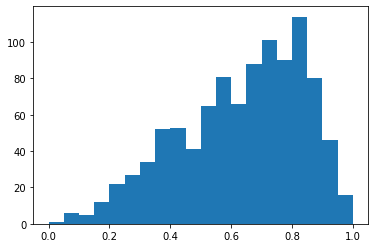

In [27]:
plt.hist(prec20train, bins=20)

In [28]:
prec20test = evaluation.precision_at_k(mf_model, test, k=20, user_features=None, item_features=None, preserve_rows=False, num_threads=4, check_intersections=True)

In [29]:
prec20test.mean()

0.15551063

In [30]:
np.median(prec20test)

0.15

(array([ 50.,   0., 134.,   0., 217.,   0., 216.,   0., 158.,   0.,   0.,
        108.,   0.,  66.,   0.,  30.,   0.,   8.,   0.,   2.]),
 array([0.        , 0.0225    , 0.045     , 0.0675    , 0.09      ,
        0.1125    , 0.13499999, 0.1575    , 0.17999999, 0.2025    ,
        0.225     , 0.24749999, 0.26999998, 0.2925    , 0.315     ,
        0.33749998, 0.35999998, 0.3825    , 0.405     , 0.42749998,
        0.45      ], dtype=float32),
 <BarContainer object of 20 artists>)

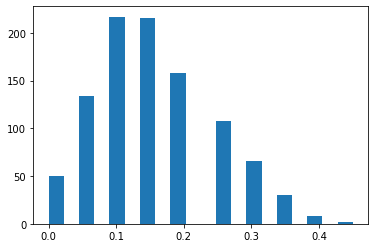

In [31]:
plt.hist(prec20test, bins=20)

## Measure the recall at k metric for a model: the number of positive items in the first k positions of the ranked list of results divided by the number of positive items in the test period. A perfect score is 1.0.

In [32]:
rec20train = evaluation.recall_at_k(mf_model, train, k=20, user_features=None, item_features=None, preserve_rows=False, num_threads=4, check_intersections=True)

In [33]:
rec20train.mean()

0.38245782620383506

In [34]:
np.median(rec20train)

0.2921747967479675

(array([  4.,  56., 146., 113.,  93.,  98.,  62.,  61.,  52.,  41.,  38.,
         32.,  22.,  24.,  23.,  19.,  21.,  14.,  13.,  68.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

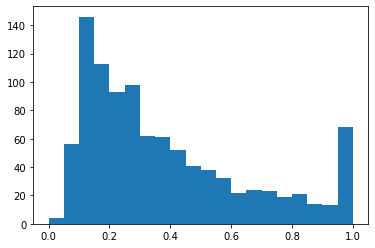

In [35]:
plt.hist(rec20train, bins=20)

In [36]:
rec20test = evaluation.recall_at_k(mf_model, test, k=20, user_features=None, item_features=None, preserve_rows=False, num_threads=4, check_intersections=True)

In [37]:
rec20test.mean()

0.37312065657249927

In [38]:
np.median(rec20test)

0.2857142857142857

(array([ 66.,  75., 121.,  84.,  87.,  94.,  70.,  27.,  58.,  12.,  70.,
         24.,   8.,  33.,   7.,  20.,  17.,   2.,   0., 114.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

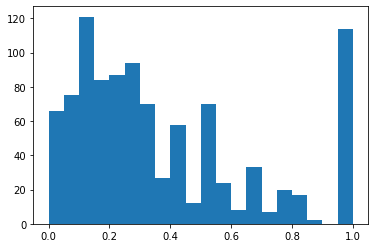

In [39]:
plt.hist(rec20test, bins=20)

## Measure the ROC AUC metric for a model: the probability that a randomly chosen positive example has a higher score than a randomly chosen negative example. A perfect score is 1.0.

In [40]:
auc = evaluation.auc_score(mf_model, test, train, user_features=None, item_features=None, preserve_rows=False, num_threads=4, check_intersections=True)

In [41]:
auc.mean()

0.99965364

In [42]:
np.median(auc)

0.99979645

(array([  2.,   0.,   1.,   4.,   8.,   5.,   4.,   7.,  11.,  16.,  14.,
         27.,  40.,  45.,  57.,  59.,  89.,  93., 141., 366.]),
 array([0.9978069 , 0.9979166 , 0.9980262 , 0.99813586, 0.99824554,
        0.99835515, 0.9984648 , 0.9985745 , 0.99868417, 0.9987938 ,
        0.99890345, 0.9990131 , 0.99912274, 0.9992324 , 0.9993421 ,
        0.99945176, 0.99956137, 0.99967104, 0.9997807 , 0.9998903 ,
        1.        ], dtype=float32),
 <BarContainer object of 20 artists>)

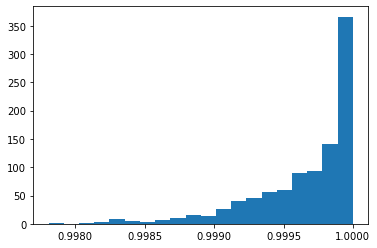

In [43]:
plt.hist(auc, bins=20)

## Should I try using hyperparameters?

## Other challenges:
- predict tracks based on playlist title [and not] and first/random [0,1,5,10,25,100] tracks

## When am I ready to try cloud computing?